In [21]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.style.use(['ggplot'])

# 1. Introduction

Collaborative ﬁltering (CF) is a popular recommendation algorithm that bases its predictions and recommendations on the ratings or behavior of other users in the system. The fundamental assumption behind this method is that other users’ opinions can be selected and aggregated in such a way as to provide a reasonable prediction of the active user’s preference.


The majority of collaborative ﬁltering algorithms in service today, including all algorithms detailed in this section, operate by ﬁrst generating predictions of the user’s preference and then produce their recommendations by ranking candidate items by predicted preferences. Often this prediction is in the same scale as the ratings provided by users, but occasionally the prediction is on a diﬀerent scale and is meaningful only for candidate ranking. This strategy is analagous to the common information retrieval method of producing relevance scores for each document in a corpus with respect to a particular query and presenting the top-scored items. Indeed, the recommend task can be viewed as an information retrieval problem in which the domain of items (the corpus) is queried with the user’s preference proﬁle.

Therefore, this section is primarily concerned with how various algorithms predict user preference. In later sections we will discuss recommendation strategies that diverge from this structure, but in actual implementation they frequently start with a preference-ranked list of items and adjust the ﬁnal recommendation list based on additional criteria.

**Reference page 89**

# 2. Load the Data

In [2]:
# read the data
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep = '\t', header = None, 
                      names = ['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)

In [3]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 07:55:49
1,186,302,3,1998-04-04 11:22:22
2,22,377,1,1997-11-06 23:18:36
3,244,51,2,1997-11-26 21:02:03
4,166,346,1,1998-02-01 21:33:16


In [4]:
ratings_df.tail()

,user_id,movie_id,rating,timestamp
99995,880,476,3,1997-11-21 21:10:44
99996,716,204,5,1997-11-17 11:39:03
99997,276,1090,1,1997-09-20 15:49:55
99998,13,225,2,1997-12-17 14:52:36
99999,12,203,3,1997-11-19 09:13:03


# 3. Baseline Predictors

**Goals:**
 
 1. Baseline models give us a foundation to compare all future models
 2. Useful baseline models maybe needed in filling with missing data for future complicated models

Before discussing true collaborative ﬁltering altorighms, let us ﬁrst consider some baseline prediction methods. These methods are useful for establishing non-personalized baselines against which personalized algorithms can be compared, as well as for pre-processing and normalizing data for use with more sophisticated algorithms. Baseline algorithms that do not depend on the user’s ratings can also be useful for providing predictions for new users.

Denote the baseline prediction for user $u$ and item $i$ by $b_{u,i}$.

In [5]:
# test for models
X_train = ratings_df.iloc[0:70000,:]
Y_train = ratings_df.iloc[70000:,:]

## 3.1 Method 1 : Simple Average Model

The simplest baseline is to predict the average rating over all ratings in the system:

$$b_{u,i} = u$$

where $u$ is overall average rating

In [6]:
class SimpleAvgModel:
    """
    @return: array; the prediction of movie ratings
    
    """
    
    def __init__(self):
        pass
    
    def fit(self, X_train):
        self.mu = X_train.iloc[:,2].mean()
        
    def predict(self, X_test):
        self.prediction = np.ones(X_test.shape[0]) * self.mu
        
        return self.prediction

In [7]:
# test = SimpleAvgModel()
# test.fit(train_df)
# test.predict(test_df)

## Method 1 (Updated) : Predict Rating by User or Item

The overall average model can be enhanced somewhat by predicting the average rating by that user or for that item:

$$ b_{u,i} = \bar{r_u} $$

$$ b_{u,i} = \bar{r_i} $$

The basic idea of `AvgIdModel` is that the model will receive `movie id` or `user id` as input and estimate averages for each movie/user in a training set. The prediction of given ID will be filled in a testing set with from each movie/user or the overall average.

In [8]:
class AvgIdModel():
    """
    @param id_name: str; input as 'movie_id' or 'user_id'
    @return: array; the prediction of movie ratings

    """

    def __init__(self, id_name):
        self.id_name = id_name

    def fit(self, X_train):

        X_train = X_train.copy()
        # get averages of each user/movie in the training set
        self.pred = X_train.groupby(self.id_name)['rating'].mean()
        # get the overall average
        self.avg = X_train['rating'].mean()

    def predict(self, X_test):

        X_test = X_test.copy()
        pred_df = X_test[[self.id_name, 'rating']].join(self.pred, on=self.id_name, rsuffix='_pred')
        pred_df.fillna(self.avg, inplace=True)

        return pred_df['rating_pred'].values


In [9]:
# test = AvgIdModel('user_id')
# test.fit(train_df)
# test.predict(test_df)

## Method 2: Regularized Effect Model

The simplest baseline model is to predict the average rating over all ratings in the system. It can be further improved by combining the user mean and the average deviation from user rating for a particular item.

The general form of another baseline model of following form can be used:

$$ b_{u,i} = u + b_u + b_i$$

where $b_u$ and $b_i$ are user and item baseline predictors respectively. 

The form of the new baseline is the ANOVA-style function. The $b_u$ and $b_i$ can be recognized as user deviance and movie deviance. Thus, the mathematical definitions of them are:

$$b_u = \frac{1}{|I_u|}\sum_{i \in I_u} (r_{u,i} - \mu)$$

and

$$b_i = \frac{1}{|U_i|}\sum_{u \in U_i} (r_{u,i} - b_u - \mu).$$


Also, the baseline model can be further regularized in order to provide more reasonable estimate of user and item preferences in face of sparse sampling, with the incorporation of damping terms $\beta_u$ and $\beta_i$:

$$b_u = \frac{1}{|I_u| + \beta_u}\sum_{i \in I_u} (r_{u,i} - \mu)$$

and

$$b_i = \frac{1}{|U_i| + \beta_i}\sum_{u \in U_i} (r_{u,i} - b_u - \mu).$$


| Variable        | Meaning                                               |
| --------------- | ----------------------------------------------------- |
| $b_{u,i}$       | Baseline rating for user $u$ on item (movie) $i$      |
| $\mu$           | The mean of all ratings                               |
| $b_u$           | The deviation from $\mu$ associated with user $u$     |
| $b_i$           | The deviation from $\mu+b_u$ associated with user $i$ |
| $I_u$           | The set of all items rated by user $u$                |
| $\mid I_u \mid$ | The number of items rated by user $u$                 |
| $\beta_u$       | Damping factor for the users ($=\beta$)               |
| $r_{u,i}$       | Observed rating for user $u$ on item $i$              |
| $U_i$           | The set of all users who rated item $i$               |
| $\mid U_i \mid$ | The number of users who rated item $i$                |
| $\beta_i$       | Damping factor for the items ($=\beta$)               |



This adjustment causes the baseline predicted ratings to be closer to global mean when the user or item has few ratings, based on the statistical principle that the more ratings a user has given or an item has received, the more is known about that user or item’s true mean rating. From [Funk's paper](https://sifter.org/~simon/journal/20061211.html), $\beta$ = 25 work well in the system

In [10]:
class RegEffectModel():
    """
    @param damping_term: int; regularized term
    @return: array; the prediction of rating scores

    """

    def __init__(self, damping_term):
        self.damping_term = damping_term

    def fit(self, X_train):

        X_train = X_train[['user_id', 'movie_id', 'rating']].copy()

        # overall_mean of ratings
        self.mu = X_train['rating'].mean()

        # bu
        I_u = X_train.groupby('user_id')['rating'].count()
        b_u = 1/(I_u + self.damping_term) * (X_train.groupby('user_id')['rating'].sum() - I_u * self.mu)
        self.b_u = b_u.rename('b_u')

        # bi
        X_train = X_train.join(self.b_u, on='user_id')
        X_train['dev_i'] = X_train['rating'] - X_train['b_u'] - self.mu
        U_i = X_train.groupby('movie_id')['rating'].count()
        b_i = 1/(U_i + self.damping_term) * (X_train.groupby('movie_id')['dev_i'].sum())
        self.b_i = b_i.rename('b_i')

    def predict(self, X_test):

        X_test = X_test[['user_id', 'movie_id']].copy()

        # join b_u and b_i for testing set
        X_test = X_test.join(self.b_u, on='user_id')
        X_test = X_test.join(self.b_i, on='movie_id')
        X_test = X_test.fillna(self.mu)

        return (self.mu + X_test['b_u'] + X_test['b_i']).values

In [11]:
# test = RegEffectModel(25)
# test.fit(X_train)
# test.predict(X_test)

# 4. Evaluation of Baseline Recommenders

We would like to apply time-independent cross-validation framework for comparsions of different methods since ratings scores are roughly consistent over time. In this project, K-folds cross validations will be used for meansuring quality of various models. 

In [14]:
X_train, X_test = train_test_split(ratings_df, test_size=0.2, shuffle = True, random_state=0)

In [15]:
def RMSE(pred_val, true_val):
    
    return np.sqrt(mean_squared_error(pred_val, true_val))

In [55]:
def Eval_Function(train_set, test_set, model, n_splits = 5, random_state = 0):

    kf = KFold(n_splits = n_splits, random_state = random_state, shuffle = True)
    valid_reuslts = []
    test_results = []
    
    for train_index, test_index in kf.split(train_set):
        # get training set and testing set
        train_df, test_df = train_set.iloc[train_index, :],train_set.iloc[test_index, :] 
        # fit model
        model.fit(train_df)
        # make prediction
        pred = model.predict(test_df)
        # calculate k RMSEs
        valid_reuslts.append(RMSE(pred, test_df['rating']))

    # caluclate RMSE in test set
    test_pred = model.predict(test_set)
    test_results.append(RMSE(test_pred, test_set['rating']))

    
    return (valid_reuslts, test_results)

In [56]:
# Calculate validation errors
val_errs1, test_errs1 = Eval_Function(X_train, X_test, SimpleAvgModel())
val_errs2, test_errs2 = Eval_Function(X_train, X_test, AvgIdModel('movie_id'))
val_errs3, test_errs3 = Eval_Function(X_train, X_test, AvgIdModel('user_id'))
val_errs4, test_errs4 = Eval_Function(X_train, X_test, RegEffectModel(0))
val_errs5, test_errs5 = Eval_Function(X_train, X_test, RegEffectModel(10))
val_errs6, test_errs6 = Eval_Function(X_train, X_test, RegEffectModel(25))
val_errs7, test_errs7 = Eval_Function(X_train, X_test, RegEffectModel(30))

## Validation Process

In [61]:
df_errs = pd.DataFrame(
    OrderedDict(
        (
            ('Average', val_errs1),
            ('Item Average', val_errs2),
            ('User Average', val_errs3),
            ('DampingFactor 0', val_errs4),
            ('DampingFactor 10', val_errs5),
            ('DampingFactor 25', val_errs6),
            ('DampingFactor 30', val_errs7),
        )
    )
)
df_errs = (
    pd.melt(df_errs, value_vars=df_errs.columns)
    .rename({'variable': 'Baseline Model', 'value': 'MAE'}, axis=1)
)

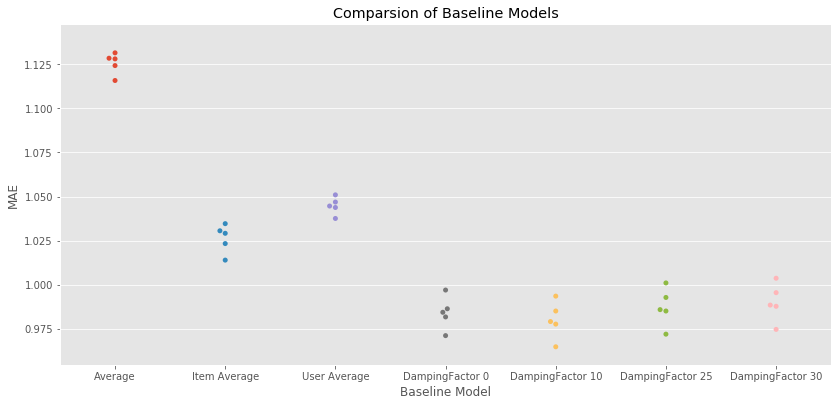

In [67]:
fig, ax = plt.subplots(figsize=(12,6))
sns.swarmplot(data=df_errs, x='Baseline Model', y='MAE', ax=ax)
ax0.xaxis.set_visible(False)
plt.tight_layout()
plt.title('Comparsion of Baseline Models')
plt.tight_layout(pad=2)
plt.savefig('Comparsion of Baseline Models.png', dpi=600)
plt.show()

## Testing Set

In [63]:
df_test_errs = pd.DataFrame(
    OrderedDict(
        (
            ('Average', test_errs1),
            ('Item Average', test_errs2),
            ('User Average', test_errs3),
            ('DampingFactor 0', test_errs4),
            ('DampingFactor 10', test_errs5),
            ('DampingFactor 25', test_errs6),
            ('DampingFactor 30', test_errs7),
        )
    )
)

In [64]:
# testing set RMSEs
df_test_errs

,Average,Item Average,User Average,DampingFactor 0,DampingFactor 10,DampingFactor 25,DampingFactor 30
0,1.12627,1.033484,1.040611,0.990597,0.986095,0.993633,0.996349
